In [2]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.load_meta import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob
from ipyfilechooser import FileChooser

In [3]:
fc = FileChooser('/sf/alvra/data/p18954/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18954/raw/scan_info', filename='', show_hidden='False')

In [109]:
quantile_band = 1

channel_list = [channel_PIPS_fluo,channel_Izero117,channel_Izero122]

################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Position_mm = scan.readbacks

Signal = []
Izero117 = []
Izero122 = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    results,pids = load_data_compact(channel_list, step)
    
    shots_even = pids%2 == 0
    shots_odd = pids%2 != 0
    
    Izero117_shot = results[channel_Izero117]#[shots_even]
    Izero122_shot = results[channel_Izero122]#[shots_even]
    signal_shot = results[channel_PIPS_fluo]#[shots_even]
    
    signal_norm_shot = signal_shot #/ Izero117_shot              #Normalization with PBPS117
#     signal_norm_shot = signal_shot / Izero122_shot              #Normalization with PBPS122
            
    df_signal = pd.DataFrame(signal_norm_shot)
    Signal.append(np.nanquantile(df_signal, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
    df_Izero117 = pd.DataFrame(Izero117_shot)
    Izero117.append(np.nanquantile(df_Izero117, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))
    
#     df_Izero122 = pd.DataFrame(Izero122_shot)
#     Izero122.append(np.nanquantile(df_Izero122, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

Position_mm = Position_mm[:np.shape(Signal)[0]]
Signal = np.asarray(Signal)
Izero117 = np.asarray(Izero117)
Izero122 = np.asarray(Izero122)

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

Step 52 of 52: Processing run_000927

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   251 / 251 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET   63 / 251 -> 75% loss ▇▇
SAROP11-PBPS117:INTENSITY 251 / 251 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 251 / 251 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 63 / 251 -> 75% loss
complete channels: 3 / 4 -> 25% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Job done!
Quantiles for error bars: 0.0,1.0


<IPython.core.display.Javascript object>


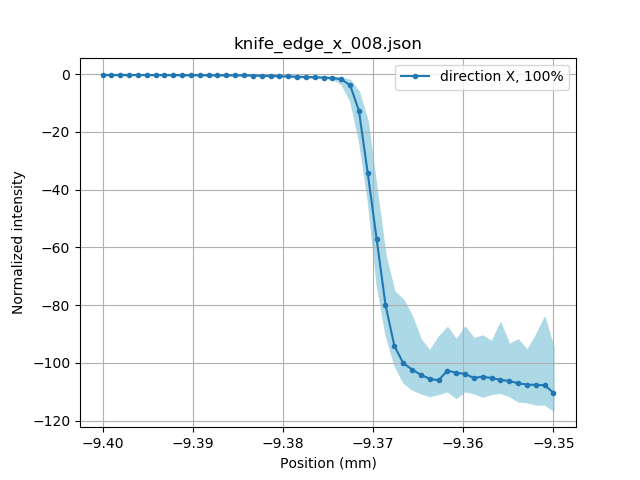

In [110]:
Int = Signal[:,0]
err_low = Signal[:,1]
err_high = Signal[:,2]

plt.figure()
plt.plot(Position_mm, Int, label='direction X, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Position_mm, err_low, err_high, color='lightblue')

plt.title(fc.selected_filename)
plt.ylabel('Normalized intensity')
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.grid()

plt.show()

<IPython.core.display.Javascript object>


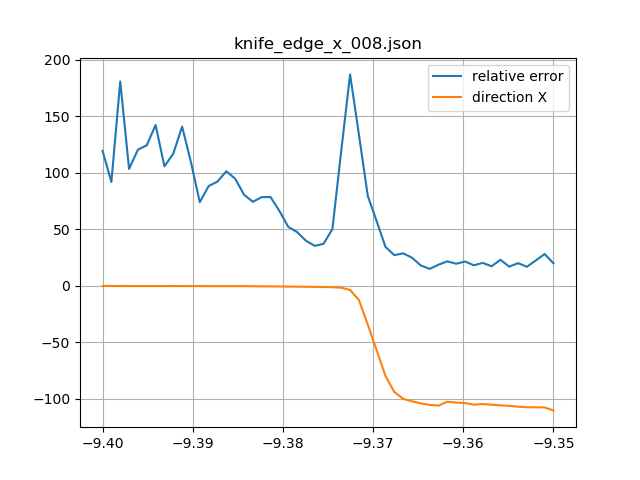

In [111]:
point = 12

band = Signal[:,2] - Signal[:,1]
value = Signal[:,0]
#print(band, value) 
#print(band/abs(value)*100)
plt.figure()
plt.title(fc.selected_filename)
plt.plot(Position_mm,band/abs(value)*100, label = 'relative error')
plt.plot(Position_mm, Int, label = 'direction X')
plt.legend(loc='best')
plt.grid()

In [114]:
# Now fit with error function (defined above)
parameters,extras = curve_fit(errfunc_fwhm, Position_mm, Int, p0 = [0, -14, -9.37, 0.1]) # [baseline, step amplitude, center, FWHM]

print("Position t0 =",(np.round(parameters[2],3)),"mm")
print("Width =",np.abs(np.round(parameters[3],3)),"mm")

Position t0 = -9.37 mm
Width = 0.004 mm


<IPython.core.display.Javascript object>


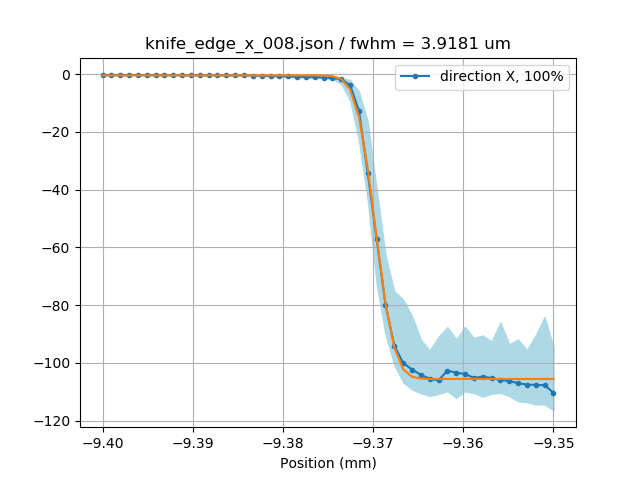

In [115]:
#... and the plot with the fit curve
plt.figure()

plt.plot(Position_mm, Int, label='direction X, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Position_mm, err_low, err_high, color='lightblue')
plt.plot(Position_mm, errfunc_fwhm(Position_mm,*parameters))

plt.title(fc.selected_filename + ' / fwhm = {} um'.format(np.round(np.abs(parameters[3])*1000, 4)))
#plt.title("X direction")
plt.grid()
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_LAM_003')